### To do:  
- collate_fn & num_workers 
- Bayesian optimisation 
- logging hyperparameter optimisation (wandb)

In [ ]:
# import os
# from pathlib import Path

# !git clone https://github.com/facebookresearch/pysparnn.git
# # cd pysparnn # cd only works on Colab if it's the only line of code in the cell 
# prev_cwd = Path.cwd()
# os.chdir('pysparnn')
# try:
#     !python setup.py install
# finally:
#     os.chdir(prev_cwd)
#     # cd ..

In [ ]:
# !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !chmod +x Miniconda3-latest-Linux-x86_64.sh
# !bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
# !conda install --quiet -y -c conda-forge python=3.7
# !conda install --quiet -y -c conda-forge rdkit

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [17]:
# !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/clean_rxn_50k_sparse_FPs_numrcts_train.npz' '/content/'
# !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/clean_rxn_50k_sparse_FPs_numrcts_valid.npz' '/content/'
# !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/clean_rxn_50k_sparse_FPs_numrcts_test.npz' '/content/'
# # !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/50k_allmols_sparse_FP_clusterIndex.bin' '/content/'
# !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/50k_allmols_sparse_FP_MONOclusterIndex.bin' '/content/'
# !cp '/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/50k_all_mols_sparse_FPs.npz' '/content/'

### Change LOCAL & cosine depending on your experiment

In [15]:
LOCAL = False # CHANGE THIS 
cosine = True # CHANGE THIS 
 
if LOCAL: 
    checkpoint_folder = 'checkpoints/'
    base_path = 'USPTO_50k_data/clean_rxn_50k_sparse_FPs_numrcts'
    if cosine:
        cluster_path = 'USPTO_50k_data/50k_allmols_sparse_FP_MONOclusterIndex.bin'
        sparseFP_vocab_path = 'USPTO_50k_data/50k_all_mols_sparse_FPs.npz'
else: # colab 
    checkpoint_folder = '/content/gdrive/My Drive/rxn_ebm/checkpoints/' 
    base_path = '/content/clean_rxn_50k_sparse_FPs_numrcts'
    if cosine:
        cluster_path = '/content/50k_allmols_sparse_FP_MONOclusterIndex.bin' 
        sparseFP_vocab_path = '/content/50k_all_mols_sparse_FPs.npz'

In [48]:
import pysparnn.cluster_index as ci

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/') 
# for Colab 
import os

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit.Chem import rdqueries # faster than iterating atoms https://sourceforge.net/p/rdkit/mailman/message/34538007/ 
from rdkit.Chem.rdchem import Atom
from rdkit import DataStructs
import numpy as np

from itertools import chain
import random

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()
import csv
import re 
import pickle
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

### utils

In [7]:
import shutil
import torch
import torch.nn as nn

def get_activation_function(activation: str) -> nn.Module:
    """
    Gets an activation function module given the name of the activation.
    Supports:
    * :code:`ReLU`
    * :code:`LeakyReLU`
    * :code:`PReLU`
    * :code:`tanh`
    * :code:`SELU`
    * :code:`ELU`
    :param activation: The name of the activation function.
    :return: The activation function module.
    """
    if activation == 'ReLU':
        return nn.ReLU()
    elif activation == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif activation == 'PReLU':
        return nn.PReLU()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'SELU':
        return nn.SELU()
    elif activation == 'ELU':
        return nn.ELU()
    else:
        raise ValueError(f'Activation "{activation}" not supported.')
    
def initialize_weights(model: nn.Module) -> None:
    """
    Initializes the weights of a model in place.
    :param model: An PyTorch model.
    """
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)
            
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

### model

In [8]:
import torch
import torch.nn as nn

class FF_ebm(nn.Module):
    '''
    trainargs: dictionary containing hyperparameters to be optimised, 
    hidden_sizes must be a list e.g. [1024, 512, 256]
    
    To do: bayesian optimisation
    '''
    def __init__(self, trainargs):
        super(FF_ebm, self).__init__()
        self.output_size = trainargs['output_size']
        self.num_layers = len(trainargs['hidden_sizes']) + 1

        if trainargs['model'] == 'FF_sep':
          self.input_dim = trainargs['rctfp_size'] + trainargs['prodfp_size'] # will be rctfp_size + prodfp_size for FF_sep
        elif trainargs['model'] == 'FF_diff':
          self.input_dim = trainargs['rctfp_size']
          assert trainargs['rctfp_size'] == trainargs['prodfp_size'], 'rctfp_size != prodfp_size, unable to make difference FPs!!!'

        self.create_ffn(trainargs)
        initialize_weights(self)  # is it necessary to initialize weights?? 
    
    def create_ffn(self, trainargs):
        '''
        Creates feed-forward network using trainargs dict
        '''
        dropout = nn.Dropout(trainargs['dropout'])
        activation = get_activation_function(trainargs['activation'])

        if self.num_layers == 1:
            ffn = [
                dropout,
                nn.Linear(self.input_dim, self.output_size)
            ]
        else:
            ffn = [
                dropout,
                nn.Linear(self.input_dim, trainargs['hidden_sizes'][0])
            ]
            
            # intermediate hidden layers 
            for i, layer in enumerate(range(self.num_layers - 2)):
                ffn.extend([
                    activation,
                    dropout,
                    nn.Linear(trainargs['hidden_sizes'][i], trainargs['hidden_sizes'][i+1]),
                ])
                
            # last hidden layer
            ffn.extend([
                activation,
                dropout,
                nn.Linear(trainargs['hidden_sizes'][-1], self.output_size),
            ])

        self.ffn = nn.Sequential(*ffn)
        
    def forward(self, batch):
        '''
        Runs FF_ebm on input
        
        batch: a N x K x 1 tensor of N training samples, where each sample contains 
        a positive rxn on the first column, and K-1 negative rxn on subsequent columns 
        supplied by DataLoader on custom ReactionDataset 
        '''
        energy_scores = self.ffn(batch) # tensor of size N x K x 1
        return energy_scores.squeeze(dim=-1)  # scores: N x K after squeezing

### train

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import time

class Run():
    '''
    epochs are 1-indexed (i.e. start from 1, 2, 3 ... not 0, 1, 2 ...)
    if load_checkpoint == True, load_optimizer, load_stats & begin_epoch must be provided 
    '''
    def __init__(self, model, trainargs,
                 load_optimizer=None, load_checkpoint=False, load_stats=None, begin_epoch=None):
        self.device = trainargs['device']
        model = model.to(self.device)
        self.model = model
        self.trainargs = trainargs 
        self.best_epoch = None # will be automatically assigned after 1 epoch
        
        if load_checkpoint: 
            assert load_optimizer is not None, 'load_checkpoint requires load_optimizer!'
            self.optimizer = load_optimizer # load optimizer w/ state dict from checkpoint
            
            assert load_stats is not None, 'load_checkpoint requires load_stats!'
            self.stats = load_stats
            self.mean_train_loss = self.stats['mean_train_loss']
            self.min_val_loss = self.stats['min_val_loss']
            self.mean_val_loss = self.stats['mean_val_loss']
            
            assert begin_epoch is not None, 'load_checkpoint requires begin_epoch!'
            self.begin_epoch = begin_epoch

        else: # init fresh optimizer 
            self.optimizer = trainargs['optimizer'](model.parameters(), lr=trainargs['learning_rate'])
            
            self.mean_train_loss = []
            self.min_val_loss = 1e9
            self.mean_val_loss = []
            self.begin_epoch = 1
            self.stats = {'trainargs': self.trainargs, 'train_time': 0} # to store training statistics  

        self.pin_memory = True if torch.cuda.is_available() else False
        train_dataset = ReactionDataset(trainargs['base_path'], 'train', trainargs)
        self.train_loader = DataLoader(train_dataset, trainargs['batch_size'], shuffle=True, pin_memory=self.pin_memory)
        self.train_size = len(train_dataset)
        
        val_dataset = ReactionDataset(trainargs['base_path'], 'valid', trainargs)
        self.val_loader = DataLoader(val_dataset, 2 * trainargs['batch_size'], shuffle=False, pin_memory=self.pin_memory)
        self.val_size = len(val_dataset)
        
        test_dataset = ReactionDataset(self.trainargs['base_path'], 'test', self.trainargs)
        self.test_loader = DataLoader(test_dataset, 2 * self.trainargs['batch_size'], shuffle=False, pin_memory=self.pin_memory)
        self.test_size = len(test_dataset)
        del train_dataset, val_dataset, test_dataset # save memory

        torch.manual_seed(trainargs['model_seed'])
        random.seed(trainargs['random_seed'])
    
    def train_one(self, batch, val=False):
        '''
        Trains model for 1 epoch
        TO DO: learning rate scheduler + logger 
        '''
        self.model.zero_grad()
        scores = self.model(batch) # size N x K 

        softmax = nn.Softmax(dim=1) 
        probs = torch.clamp(softmax(scores), min=1e-12) # size N x K, clamped to >= 1e-12 for safe log 

        # positives are the 0-th index of each sample 
        loss = -torch.log(probs[:, 0]).sum() # probs[:, 0] is size N x 1 --> sum/mean to 1 value

        if not val:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.item()

    def train(self):
        '''
        Trains model for epochs provided in trainargs
        Currently supports feed-forward networks: 
            FF_diff: takes as input a difference FP of fp_size & fp_radius
            FF_sep: takes as input a concatenation of [reactants FP, product FP] 
        '''
        start = time.time()

        for epoch in np.arange(self.begin_epoch, self.trainargs['epochs']): # epochs are 1-indexed (as of 27th Aug 2 am)
            self.model.train() # set model to training mode
            train_loss = []
            for batch in tqdm(self.train_loader): 
                batch = batch.to(self.device)
                train_loss.append(self.train_one(batch, val=False))
            self.mean_train_loss.append(np.sum(train_loss) / self.train_size) 

            self.model.eval() # validation mode
            val_loss = []
            with torch.no_grad():
                for batch in tqdm(self.val_loader):
                    batch = batch.to(self.device)
                    val_loss.append(self.train_one(batch, val=True))
                
                self.mean_val_loss.append(np.sum(val_loss) / self.val_size)
                if self.trainargs['early_stop'] and \
                self.min_val_loss - self.mean_val_loss[-1] < self.trainargs['min_delta']:
                    if self.trainargs['patience'] <= wait:
                        print('Early stopped at the end of epoch: ', epoch)
                        print('mean_val_loss: ', self.mean_val_loss[-1])
                        self.stats['early_stop_epoch'] = epoch 
                        break 
                    else:
                        wait += 1
                        print('Decrease in val loss < min_delta, patience count: ', wait)
                else:
                    wait = 0
                    self.min_val_loss = min(self.min_val_loss, self.mean_val_loss[-1])
                
                if self.mean_val_loss[-1] < self.min_val_loss:
                    self.best_epoch = epoch # track best_epoch to load best_checkpoint 

            self.stats['mean_train_loss'] = self.mean_train_loss
            self.stats['mean_val_loss'] = self.mean_val_loss
            self.stats['min_val_loss'] = self.min_val_loss
            self.stats['best_epoch'] = self.best_epoch

            if self.trainargs['checkpoint']: # adapted from moco: main_moco.py
                save_checkpoint({
                        'epoch': epoch, # epochs are 1-indexed
                        'model': self.trainargs['model'],
                        'state_dict': self.model.state_dict(),
                        'optimizer' : self.optimizer.state_dict(),
                        'stats' : self.stats,
                    }, is_best=False, 
                    filename=self.trainargs['checkpoint_path']+'{}_{}_checkpoint_{:04d}.pth.tar'.format(
                        self.trainargs['model'], self.trainargs['expt_name'], epoch))
                # checkpoint stats also 
                torch.save(self.stats, self.trainargs['checkpoint_path']+'{}_{}_stats.pkl'.format(
                      self.trainargs['model'], self.trainargs['expt_name']))
                
            print('Epoch: {}, train_loss: {}, val_loss: {}'.format(epoch, 
                                             np.around(self.mean_train_loss[-1], decimals=4), 
                                             np.around(self.mean_val_loss[-1], decimals=4)))
            
        self.stats['train_time'] += (time.time() - start) / 60
        torch.save(self.stats, self.trainargs['checkpoint_path']+'{}_{}_stats.pkl'.format(
            self.trainargs['model'], self.trainargs['expt_name']))         # save final training stats

    def test(self, load_stats=None):
        '''
        Evaluates the model on the test set
        '''
        sum_test_loss, test_loss = [], []
        
        self.model.eval()
        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                batch = batch.to(self.device)
                sum_test_loss.append(self.train_one(batch, val=True))
                test_loss.append(sum_test_loss[-1] / len(batch))
        
        if load_stats is not None: 
            self.stats = load_stats 
        assert len(self.stats.keys()) > 1, 'If loading checkpoint, you need to provide load_stats!'
        
        self.stats['test_loss'] = test_loss 
        self.stats['mean_test_loss'] = np.sum(sum_test_loss) / self.test_size
        print('train_time: {}'.format(self.stats['train_time']))
        print('test_loss: {}'.format(self.stats['test_loss']))
        print('mean_test_loss: {}'.format(self.stats['mean_test_loss']))

        # overrides existing training stats w/ training + test stats
        torch.save(self.stats, self.trainargs['checkpoint_path']+'{}_{}_stats.pkl'.format(
            self.trainargs['model'], self.trainargs['expt_name']))

    def get_scores(self, dataloader, save_neg=False):
        ''' 
        Gets raw energy values (scores) from a trained model on a given dataloader,
        with the option to save pos_neg_smis to analyse model performance
        
        TO DO: fix save_neg: index into SMILES molecule vocab to retrieve molecules --> 
        save as groups [true product/rct SMILES, 1st NN SMILES, ... K-1'th NN SMILES])
        '''
        scores = []
        self.model.eval()
        with torch.no_grad():
            if save_neg:      # save neg rxn_smis to analyse model performance           
                pos_neg_smis = []
                for pos_neg_smi, batch in tqdm(dataloader):
                    batch = batch.to(self.device)
                    scores.append(self.model(batch).cpu()) # scores: size N x K 
                    pos_neg_smis.append(pos_neg_smi)
                torch.save(pos_neg_smis, self.trainargs['checkpoint_path']+'{}_{}_posnegsmi.pkl'.format(
                        self.trainargs['model'], self.trainargs['expt_name']))
                
                return torch.cat(scores, dim=0), pos_neg_smis
            else:
                for batch in tqdm(dataloader):
                    batch = batch.to(self.device)
                    scores.append(self.model(batch).cpu())
                
                return torch.cat(scores, dim=0)

    def get_topk_acc(self, dataloader, k=1, repeats=1, toprint=True):
        '''
        Computes top-k accuracy of trained model in classifying feasible vs infeasible chemical rxns
        (i.e. maximum score assigned to label 0 of each training sample) 
        
        Returns: (list of accs, mean acc, variance of acc)
        '''
        accs = np.array([])
        for repeat in range(repeats):
            scores = self.get_scores(dataloader)
            predicted_labels = torch.topk(scores, k, dim=1)[1]
            accs = np.append(accs, torch.where(predicted_labels == 0)[0].shape[0] / predicted_labels.shape[0])
            
        if toprint:
            print('Top-1 accuracies: ', accs)
            print('Avg top-1 accuracy: ', accs.mean())
            print('Variance: ', accs.var())

        return accs, accs.mean(), accs.var()

### data

In [45]:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/data_loading_tutorial.py
import torch
from torch.utils.data import Dataset
import random
import pickle
from scipy import sparse 

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
import numpy as np

def create_rxn_MorganFP_fromFP(raw_fp, num_rcts, fp_type='diff', 
                               rctfp_size=4096, prodfp_size=4096, dtype='int8'):
    '''
    fp_type: 'diff' or 'sep', 
    'diff' (difference):
    Creates reaction MorganFP following Schneider et al in J. Chem. Inf. Model. 2015, 55, 1, 39–53
    reactionFP = productFP - sum(reactantFPs)
    
    'sep' (separate):
    Creates separate reactantsFP and productFP following Gao et al in ACS Cent. Sci. 2018, 4, 11, 1465–1476
    '''
    # initialise empty fp numpy arrays
    if fp_type == 'diff':
        diff_fp = np.zeros(rctfp_size, dtype = dtype)
    elif fp_type == 'sep':
        rcts_fp = np.zeros(rctfp_size, dtype = dtype)
        prod_fp = np.zeros(prodfp_size, dtype = dtype)
    else:
        print('ERROR: fp_type not recognised!')
        return
    
    # create product FP
    try:
        fp = raw_fp[-1]
        if fp_type == 'diff':
            diff_fp += fp
        elif fp_type == 'sep':
            prod_fp = fp
    except Exception as e:
        print("Cannot build product fp due to {}".format(e))
        return
                                  
    # create reactant FPs, subtracting each from product FP
    for i in range(num_rcts):
        try:
            fp = raw_fp[i]
            if fp_type == 'diff':
                diff_fp -= fp
            elif fp_type == 'sep':
                rcts_fp += fp
        except Exception as e:
            print("Cannot build reactant fp due to {}".format(e))
            return
    
    if fp_type == 'diff':
        return diff_fp
    elif fp_type == 'sep':
        return np.concatenate([rcts_fp, prod_fp])
    
    
class ReactionDataset(Dataset):
    '''
    The Dataset class ReactionDataset prepares training samples of length K: 
    [pos_rxn, neg_rxn_1, ..., neg_rxn_K-1], ... where K-1 = num_neg 

    TO DO: can this be further optimised? Augmentation is the clear bottleneck during training
    '''
    def __init__(self, base_path, key, trainargs, 
                 show_neg=False, # for visualising nearest neighbors 
                 save_neg=False): # for rxn_smi (to fix later on)
        '''
        base_path is of the form: 'USPTO_50k_data/clean_rxn_50k_sparse_FPs', and according to key parameter,
        the correct full path will be used e.g. 'USPTO_50k_data/clean_rxn_50k_sparse_FPs_train.npz'
        ''' 
        self.fp_raw_num_rcts = sparse.load_npz(base_path + '_' + key + '.npz')
        if 'cluster_path' in trainargs.keys(): # doing cosine similarity search
            with open(trainargs['cluster_path'], 'rb') as handle:
                self.clusterindex = pickle.load(handle)
                
            assert 'sparseFP_vocab_path' in trainargs.keys(), 'You provided cluster_path but not sparseFP_vocab_path!!'
            self.sparseFP_vocab = sparse.load_npz(trainargs['sparseFP_vocab_path'])
            
            assert 'num_neg_prod' in trainargs.keys() and 'num_neg_rct' in trainargs.keys(), \
            'You provided cluster_path but not num_neg_prod and num_neg_rct!'
            self.num_neg_prod = trainargs['num_neg_prod']
            self.num_neg_rct = trainargs['num_neg_rct']
        else:
            assert 'num_neg' in trainargs.keys(), 'You did not provide num_neg!'
            self.num_neg = trainargs['num_neg']
        
        self.fp_type = trainargs['fp_type']
        
        self.fp_radius = trainargs['fp_radius'] # not needed if loading pre-computed fingerprints
        self.rctfp_size = trainargs['rctfp_size']
        self.prodfp_size = trainargs['prodfp_size']
        assert trainargs['rctfp_size'] == trainargs['prodfp_size']
        self.save_neg = save_neg
        self.show_neg = show_neg

    def random_sample_negative(self, raw_fp, num_rcts):
        '''
        Randomly generates 1 negative rxn given a positive rxn fingerprint
        Returns neg_rxn_fp (fingerprint)
        ''' 
        rdm_rxn_idx = random.choice(np.arange(self.fp_raw_num_rcts.shape[0])) 
        new_fp_raw_num_rcts = self.fp_raw_num_rcts[rdm_rxn_idx].toarray()
        new_raw_fp, _ = np.split(new_fp_raw_num_rcts, [new_fp_raw_num_rcts.shape[-1]-1], axis=1)
        new_raw_fp = new_raw_fp.reshape(-1, self.rctfp_size)  
        
        rct_or_prod = random.choice([0, 1])
        if rct_or_prod == 0: # randomly change one of the reactant(s)
            rct_idx = random.choice(np.arange(num_rcts)) # randomly choose 1 reactant to be replaced
            raw_fp[rct_idx, :] = new_raw_fp[rct_idx, :] 
        else:  # randomly change product 
            raw_fp[-1, :] = new_raw_fp[-1, :] 
        return raw_fp 
    
    def cosine_sample_negative(self, raw_fp, num_rcts):
        ''' 
        Replace product w/ approx nearest neighbor based on cosine similarity 
        
        Args:
            raw_fp: dense nparray fp of shape (max #rcts + 1, self.rctfp_size); for USPTO-50k, max #rcts = 4
        
        Returns:
            list of num_neg X dense nparrays of the same shape as raw_fp, with product replaced 
        '''
        rct_idx = random.choice(np.arange(num_rcts))
        first_rct_prod_sparse = sparse.csr_matrix(raw_fp.copy()[[rct_idx, -1]], dtype='int8')
        nn_rct_indices, nn_prod_indices = self.clusterindex.search(first_rct_prod_sparse, k=max(self.num_neg_prod, self.num_neg_rct)+1, 
                                                   return_distance=False)     #[0][1:]
        nn_prod_indices, nn_rct_indices = [int(idx) for idx in nn_prod_indices], [int(idx) for idx in nn_rct_indices]
        nn_prod_FPs = [self.sparseFP_vocab[idx].toarray() for idx in nn_prod_indices[1: self.num_neg_prod + 1]]
        nn_rct_FPs = [self.sparseFP_vocab[idx].toarray() for idx in nn_rct_indices[1: self.num_neg_rct + 1]] # 1 x 4096 nparray

        rct_FP_out = []
        for rct_FP in nn_rct_FPs: # not sure how to do this via list comprehension to optimize it (lambda? but is it slower than for loop)
          outputFP = raw_fp.copy()
          outputFP[rct_idx] = rct_FP
          rct_FP_out.append(outputFP)
        
        if self.show_neg:
          return [np.vstack((raw_fp[:-1], FP)) for FP in nn_prod_FPs] + rct_FP_out, nn_prod_indices, nn_rct_indices
        else:
          return [np.vstack((raw_fp[:-1], FP)) for FP in nn_prod_FPs] + rct_FP_out

    def __getitem__(self, idx):
        ''' 
        Returns 1 training sample in the form [pos_rxn_fp, neg_rxn_1_fp, ..., neg_rxn_K-1_fp]
        num_neg: a hyperparameter to be tuned
        '''
        if torch.is_tensor(idx): 
            idx = idx.tolist() 

        fp_raw_num_rcts = self.fp_raw_num_rcts[idx].toarray() 
        pos_raw_fp, num_rcts = np.split(fp_raw_num_rcts, [fp_raw_num_rcts.shape[-1]-1], axis=1) 
        pos_raw_fp = pos_raw_fp.reshape(-1, self.rctfp_size) 
        num_rcts = num_rcts[0][0]
        pos_rxn_fp = create_rxn_MorganFP_fromFP(pos_raw_fp.copy(), num_rcts, fp_type=self.fp_type, 
                                                rctfp_size=self.rctfp_size, prodfp_size=self.prodfp_size)

        assert self.num_neg_prod > 0 and self.num_neg_rct > 0, 'num_neg cannot be negative!'   
        if 'cluster_path' in trainargs.keys(): # cosine similarity search
          if self.show_neg:
            neg_raw_fps, nn_prod_indices, nn_rct_indices = self.cosine_sample_negative(pos_raw_fp, num_rcts)
          else:
            neg_raw_fps = self.cosine_sample_negative(pos_raw_fp, num_rcts)
        else:
            neg_raw_fps = [self.random_sample_negative(pos_raw_fp.copy(), num_rcts) for i in range(self.num_neg)]
        neg_rxn_fps = [create_rxn_MorganFP_fromFP(neg_raw_fp.copy(), num_rcts, fp_type=self.fp_type, 
                                                  rctfp_size=self.rctfp_size, prodfp_size=self.prodfp_size)
                        for neg_raw_fp in neg_raw_fps]
        if self.show_neg:
          return torch.Tensor([pos_rxn_fp, *neg_rxn_fps]), nn_prod_indices, nn_rct_indices
        else:
          return torch.Tensor([pos_rxn_fp, *neg_rxn_fps])

    def __len__(self):
        return self.fp_raw_num_rcts.shape[0]

In [ ]:
test_dataset_showneg = ReactionDataset(stats['trainargs']['base_path'], 'test', stats['trainargs'], show_neg=True)

In [ ]:
with open('/content/gdrive/My Drive/rxn_ebm/USPTO_50k_Schneider/50k_unique_rcts_prod_smis.pickle', 'rb') as handle:
    unique_mols_50k = pickle.load(handle)

In [ ]:
too_similar_idx = torch.where(scores[:, 0] == scores[:, 1])
scores[too_similar_idx[0][986]], len(too_similar_idx[0])

(tensor([ -4.0585,  -4.0585, -17.4343, -12.1690,  -8.2925]), 987)

In [ ]:
diff_fps = test_dataset_showneg.__getitem__(too_similar_idx[0][986])[0]
torch.all(diff_fps[0] == diff_fps[1]), torch.all(diff_fps[0] == diff_fps[2]), torch.all(diff_fps[0] == diff_fps[3]), torch.all(diff_fps[0] == diff_fps[4])

(tensor(True), tensor(False), tensor(False), tensor(False))

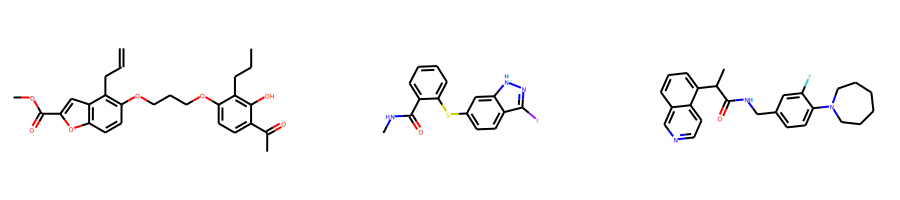

In [ ]:
nn_prod_indices = test_dataset_showneg.__getitem__(too_similar_idx[0][986])[1]
result_mols = [Chem.MolFromSmiles(unique_mols_50k[idx]) for idx in nn_prod_indices]
Draw.MolsToGridImage(result_mols, subImgSize=(300, 200))

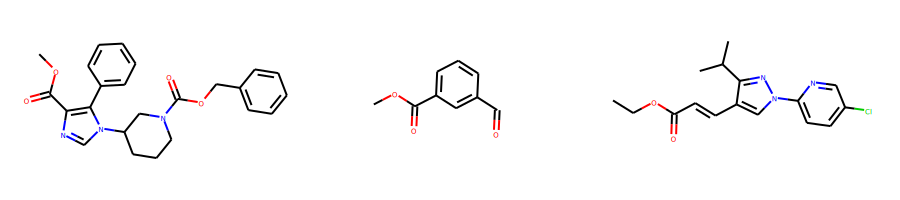

In [ ]:
nn_rct_indices = test_dataset_showneg.__getitem__(too_similar_idx[0][986])[2]
result_mols = [Chem.MolFromSmiles(unique_mols_50k[idx]) for idx in nn_rct_indices]
Draw.MolsToGridImage(result_mols, subImgSize=(300, 200))

### Train and Test

In [46]:
trainargs = {
    'model': 'FF_diff', # must change both model & fp_type 
    'hidden_sizes': [384],  
    'output_size': 1,
    'dropout': 0.2,  
    
    'batch_size': 64,
    'activation': 'ReLU',  
    'optimizer': torch.optim.Adam,
    'learning_rate': 5e-3, # to try: lr_finder & lr_schedulers 
    'epochs': 50,
    'early_stop': True,
    'min_delta': 1e-4, # we just want to watch out for when val_loss increases
    'patience': 2,

    'checkpoint': True,
    'model_seed': 1337,
    'random_seed': 0, # affects neg rxn sampling since it is random
    
    'rctfp_size': 4096, # if fp_type == 'diff', ensure that both rctfp_size & prodfp_size are identical!
    'prodfp_size': 4096,
    'fp_radius': 3,
    'fp_type': 'diff',
    
    'num_neg_prod': 5,
    'num_neg_rct': 5,
    
    'base_path': base_path, # refer to top of notebook 
    'checkpoint_path': checkpoint_folder,
    'cluster_path': cluster_path,
    'sparseFP_vocab_path': sparseFP_vocab_path,
 
    'expt_name': 'MONO_cosine_4096_1layer384_PERMUTE5prod5rct_rad3_ReLU_drop2',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

In [49]:
model = FF_ebm(trainargs)
run = Run(model, trainargs)

### options to speed up:
- precompute nearest neighbors (i.e. only need to calculate once, store as sparseFPs)
- ~use separate num_rcts list~ 
- ~use mono ClusterIndex (~2x faster) but sacrifice some recall~
- is np.vstack slow? 
- lower num_neg but may sacrifice model performance
- think about how to design a collate_fn 

In [50]:
run.train()

  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.9462, val_loss: 0.4481


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.5276, val_loss: 0.3477


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.4079, val_loss: 0.3235


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.347, val_loss: 0.2956


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.3086, val_loss: 0.2833


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.2797, val_loss: 0.2769


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.2609, val_loss: 0.2724


  0%|          | 0/626 [00:00<?, ?it/s]

Decrease in val loss < min_delta, patience count:  1
Epoch: 8, train_loss: 0.2446, val_loss: 0.276


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.2267, val_loss: 0.2705


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 10, train_loss: 0.2169, val_loss: 0.2637


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 11, train_loss: 0.211, val_loss: 0.2624


  0%|          | 0/626 [00:00<?, ?it/s]

Epoch: 12, train_loss: 0.1963, val_loss: 0.2611


  0%|          | 0/626 [00:00<?, ?it/s]

Decrease in val loss < min_delta, patience count:  1
Epoch: 13, train_loss: 0.1919, val_loss: 0.2655


  0%|          | 0/626 [00:00<?, ?it/s]

Decrease in val loss < min_delta, patience count:  2
Epoch: 14, train_loss: 0.187, val_loss: 0.266


100%|██████████| 40/40 [00:58<00:00,  1.45s/it]

Early stopped at the end of epoch:  15
mean_val_loss:  0.2712373028896113


In [51]:
run.test()

100%|██████████| 40/40 [00:57<00:00,  1.43s/it]

train_time: 134.98899006843567
test_loss: [0.34486013650894165, 0.21350349485874176, 0.316318541765213, 0.3600781559944153, 0.3259674608707428, 0.30812811851501465, 0.3269449472427368, 0.19993144273757935, 0.3359689712524414, 0.300240159034729, 0.257930725812912, 0.278262197971344, 0.24062779545783997, 0.33006447553634644, 0.4392233192920685, 0.48624366521835327, 0.3170953691005707, 0.3175897002220154, 0.1483258455991745, 0.2761147618293762, 0.18926283717155457, 0.33126699924468994, 0.303907573223114, 0.19922403991222382, 0.28010982275009155, 0.17266088724136353, 0.19850485026836395, 0.18065138161182404, 0.3039328455924988, 0.30969226360321045, 0.18357282876968384, 0.27592340111732483, 0.24500435590744019, 0.17461293935775757, 0.26065805554389954, 0.39882993698120117, 0.23924529552459717, 0.26926708221435547, 0.15476784110069275, 0.11207989056905111]
mean_test_loss: 0.2762890068242382


In [52]:
test_dataset = ReactionDataset(trainargs['base_path'], 'test', trainargs)
test_loader = DataLoader(test_dataset, 2 * trainargs['batch_size'], shuffle=False)

run.get_topk_acc(test_loader, 1, repeats=1)

100%|██████████| 40/40 [00:56<00:00,  1.42s/it]

Top-1 accuracies:  [0.91471939]
Avg top-1 accuracy:  0.91471939285001
Variance:  0.0


(array([0.91471939]), 0.91471939285001, 0.0)

In [53]:
scores = run.get_scores(test_loader)

100%|██████████| 40/40 [00:58<00:00,  1.45s/it]


In [54]:
scores[0:20]

tensor([[-12.3080, -27.3587, -28.1888, -28.0778, -26.1979, -32.6639, -18.0499,
         -21.9614, -20.7868, -22.0446, -23.1673],
        [-18.4102, -49.4610, -45.9350, -50.6376, -47.8758, -49.2555, -20.8611,
         -21.2184, -29.7202, -29.4258, -28.7391],
        [ -9.1878, -19.4630, -21.0764, -42.5246, -44.0958, -44.7666, -26.7794,
         -23.3455, -30.4753, -27.2496, -32.9655],
        [-12.3116, -23.4847, -26.6976, -37.9741, -39.0944, -41.2545, -20.6920,
         -23.0860, -22.7468, -22.0501, -21.4243],
        [ -8.7711, -18.8178, -38.3750, -26.8047, -36.3992, -37.1154, -23.0179,
         -24.7012, -24.3654, -25.1083, -28.7611],
        [-11.8389, -26.9684, -25.5917, -22.5330, -22.2901, -20.2715, -28.5865,
         -24.0738, -30.3429, -29.0659, -31.0904],
        [-16.0913, -24.5893, -36.2138, -42.3736, -38.9018, -44.0648, -24.5893,
         -35.1414, -30.9030, -30.5106, -29.9173],
        [-10.9674, -12.3991, -13.2561, -23.1595, -20.1408, -25.0833, -20.0677,
         -22.8411,

In [55]:
torch.where(scores[:, 0] == scores[:, 1])[0].shape

torch.Size([4])

In [56]:
print('% of test samples w/ same score assigned to pos_rxn & nearest prod: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 1])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & 2nd nearest prod: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 2])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & nearest rct: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 4])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & 2nd nearest rct: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 5])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & nearest rct & prod (in same sample): {:.5f}'.format( 
      len(torch.where((scores[:, 0] == scores[:, 4]) & (scores[:, 0] == scores[:, 1]))[0]) / len(test_dataset) * 100))

% of test samples w/ same score assigned to pos_rxn & nearest prod: 0.07989
% of test samples w/ same score assigned to pos_rxn & 2nd nearest prod: 0.00000
% of test samples w/ same score assigned to pos_rxn & nearest rct: 0.00000
% of test samples w/ same score assigned to pos_rxn & 2nd nearest rct: 0.00000
% of test samples w/ same score assigned to pos_rxn & nearest rct & prod (in same sample): 0.00000


In [57]:
torch.save(scores, '/content/gdrive/My Drive/rxn_ebm/scores_sepnumneg_fixed_MONO_PERMUTE.pkl')

In [ ]:
import IPython.display as display
display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True)

### load checkpoint and resume training

In [ ]:
LOCAL = False # CHANGE THIS 
cosine = True # CHANGE THIS 
 
if LOCAL: 
    checkpoint_folder = 'checkpoints/'
    base_path = 'USPTO_50k_data/clean_rxn_50k_sparse_FPs_numrcts'
    if cosine:
        cluster_path = 'USPTO_50k_data/50k_allmols_sparse_FP_clusterIndex.bin'
        sparseFP_vocab_path = 'USPTO_50k_data/50k_all_mols_sparse_FPs.npz'
else: # colab 
    checkpoint_folder = '/content/gdrive/My Drive/rxn_ebm/checkpoints/' 
    base_path = '/content/clean_rxn_50k_sparse_FPs_numrcts'
    if cosine:
        cluster_path = '/content/50k_allmols_sparse_FP_clusterIndex.bin' 
        sparseFP_vocab_path = '/content/50k_all_mols_sparse_FPs.npz'

filenames = [filename for filename in os.listdir(checkpoint_folder) 
             if 'separate' in filename] # narrow down list 
filenames

['FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0001.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0002.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0003.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0004.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0005.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0006.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0007.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0008.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0009.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0010.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0011.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0012.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0013.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkpoint_0014.pth.tar',
 'FF_diff_test_cosine_separate_num_neg_v2_checkp

In [ ]:
opt = 'Adam' # needed to fix bug in name of optimizer when saving checkpoint
stats_filename = 'FF_diff_test_cosine_separate_num_neg_v2_stats.pkl' # copy & paste from list above 
# filenames must end w/ stats.pkl

curr_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stats = torch.load(checkpoint_folder + stats_filename, 
          map_location=torch.device('cpu'))
stats['trainargs']['base_path'] = base_path
stats['trainargs']['checkpoint_path'] = checkpoint_folder
stats['trainargs']['cluster_path'] = cluster_path
stats['trainargs']['sparseFP_vocab_path'] = sparseFP_vocab_path

if opt == 'Adam':
    stats['trainargs']['optimizer'] = torch.optim.Adam # fix bug in name of optimizer when saving checkpoint

stats['best_epoch'] = stats['mean_val_loss'].index(stats['min_val_loss']) + 1  # 1-index 
stats['trainargs']['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
try: 
    checkpoint_filename = stats_filename[:-9]+'checkpoint_{}.pth.tar'.format(str(stats['best_epoch']).zfill(4)) 
    checkpoint = torch.load(checkpoint_folder + checkpoint_filename,
          map_location=torch.device(curr_device))

    model = FF_ebm(stats['trainargs'])
    optimizer = stats['trainargs']['optimizer'](model.parameters(), lr=stats['trainargs']['learning_rate'])

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    if torch.cuda.is_available(): # move optimizer tensors to gpu  https://github.com/pytorch/pytorch/issues/2830
      for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.cuda()
except Exception as e:
    print(e)
    print('best_epoch: {}'.format(stats['best_epoch']))

In [ ]:
# trainargs = {'activation': 'ReLU',
#  'batch_size': 512,
#  'checkpoint': True,
#  'checkpoint_path': checkpoint_folder,
#  'device': curr_device,
#  'cluster_path': cluster_path,
#  'sparseFP_vocab_path': sparseFP_vocab_path,
#  'dropout': 0.1,
#  'early_stop': True,
#  'epochs': 50,
#  'expt_name': 'cosine_4096_1layer_3neg_rad3_ReLU', # change this if needed
#  'fp_radius': 3,
#  'fp_type': 'diff',
#  'hidden_sizes': [256],
#  'learning_rate': 1e-4,
#  'min_delta': 1e-4,
#  'model': 'FF_diff',
#  'model_seed': 1337,
#  'num_neg': 5,
#  'optimizer': torch.optim.Adam,
#  'output_size': 1,
#  'base_path': base_path, 
#  'patience': 3, 
#  'prodfp_size': 4096,
#  'random_seed': 0,
#  'rctfp_size': 4096}   

In [ ]:
run = Run(model, stats['trainargs'], optimizer, load_checkpoint=True, load_stats=stats, begin_epoch=stats['best_epoch'])
# run.train()

In [ ]:
run.test()

In [ ]:
test_dataset = ReactionDataset(stats['trainargs']['base_path'], 'test', stats['trainargs'])
test_loader = DataLoader(test_dataset, 2 * stats['trainargs']['batch_size'], shuffle=False)

run.get_topk_acc(test_loader, 1, repeats=1)

In [ ]:
test_dataset = ReactionDataset(stats['trainargs']['base_path'], 'test', stats['trainargs'])
test_loader = DataLoader(test_dataset, 2 * stats['trainargs']['batch_size'], shuffle=False)

scores = run.get_scores(test_loader)

In [ ]:
torch.where(scores[:, 0] == scores[:, 1])

In [ ]:
print('% of test samples w/ same score assigned to pos_rxn & nearest prod: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 1])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & 2nd nearest prod: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 2])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & nearest rct: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 3])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & 2nd nearest rct: {:.5f}'.format( 
      len(torch.where(scores[:, 0] == scores[:, 4])[0]) / len(test_dataset) * 100))

print('% of test samples w/ same score assigned to pos_rxn & nearest rct & prod (in same sample): {:.5f}'.format( 
      len(torch.where((scores[:, 0] == scores[:, 4]) & (scores[:, 0] == scores[:, 1]))[0]) / len(test_dataset) * 100))

In [ ]:
(torch.where(scores[:, 0] < scores[:, 1])[0].numpy().shape[0], 
torch.where(scores[:, 0] < scores[:, 2])[0].numpy().shape[0], 
torch.where(scores[:, 0] < scores[:, 3])[0].numpy().shape[0],
torch.where(scores[:, 0] < scores[:, 4])[0].numpy().shape[0])
# torch.where(scores[:, 0] < scores[:, 5])[0].numpy().shape[0])

In [ ]:
softmax = nn.Softmax(dim=1) 
probs = torch.clamp(softmax(scores), min=1e-12)

In [ ]:
probs

In [ ]:
probs[probs[:, 0].argmin().item()]